In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# from degree_days import dds
import datetime
from sklearn.model_selection import train_test_split, KFold
import sys
sys.path.insert(0, '../../aaai18/code/')
from tensor_custom_core import *
from common import *
from create_matrix import *

appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

import os

def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [3]:
import sys
from degree_days import dds
case=2
a = 3
b = 3
source = 'Austin'
target = 'SanDiego'
constant_use = 'True'
start = 1
stop = 13

In [4]:
def get_tensor_appliance(df, dfc, appliance):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] ]).flatten()
    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 1, stop - start))
    M, N, O = tensor.shape
    return tensor

In [5]:
source_df, source_dfc, source_tensor, source_static = create_region_df_dfc_static(source, year, start, stop)
target_df, target_dfc, target_tensor, target_static = create_region_df_dfc_static(target, year, start, stop)

# # using cosine similarity to compute L
source_L = get_L(source_static)
target_L = get_L(target_static)

# Seasonal constant constraints
if constant_use == 'True':
    T_constant = np.ones(stop-start).reshape(-1 , 1)
else:
    T_constant = None

In [6]:
agg_target = get_tensor_appliance(target_df, target_dfc, 'aggregate')
agg_source = get_tensor_appliance(source_df, source_dfc, 'aggregate')


# Use aggregate readings to learn Home factors

In [7]:
tensor_copy = agg_source.copy()
H_agg, A_agg, T_agg, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            source_L,
                                                          a,
                                                          b,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

966.937568532
214.410186558
157.061137637
151.868008603
150.866687301
150.630796813


In [9]:
tensor_copy = agg_target.copy()
H_agg_t, A_agg_t, T_agg_t, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            target_L,
                                                          a,
                                                          b,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                        A_known=A_agg,
                                                          T_known=T_constant)

459.296909468
72.0298864612
71.8028108054
71.8016620804
71.8006089915
71.7995083247


In [11]:
H_agg = H_agg_tmp

# Use all readings to learn Home factors

In [12]:
tensor_copy = source_tensor.copy()
H_all, A_all, T_all, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            source_L,
                                                          a,
                                                          b,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

498.390915785
140.09512203
101.379737927
88.5219212457
83.0967795185
79.9035478544


In [13]:
tensor_copy = target_tensor.copy()
H_all_t, A_all_t, T_all_t, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            target_L,
                                                          a,
                                                          b,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                        A_known=A_all,
                                                          T_known=T_constant)

207.974345856
37.1253546256
33.9132419478
33.1844741475
32.9334721246
32.8172106333


In [41]:
H_all = np.r_[H_all, H_all_t]
len(H_all)

572

In [46]:
from sklearn.cluster import KMeans
X = {}
y_pred = {}
x1 = {}
x2 = {}
# for home factors learnt from aggregate readings
X[0] = H_agg.copy()
X[0] = X[0]/np.max(X[0])
y_pred[0] = KMeans(n_clusters=15, random_state=0).fit_predict(X[0])
x1[0], x2[0] = (-np.var(X[0], axis=0)).argsort()[:2]
# for home factors learnt from all readings
X[1] = H_all.copy()
X[1] = X[1]/np.max(X[1])
y_pred[1] = KMeans(n_clusters=15, random_state=0).fit_predict(X[1])
x1[1], x2[1] = (-np.var(X[1], axis=0)).argsort()[:2]

array([[ 0.10056375,  0.11597327,  0.09803194],
       [ 0.33429796,  0.31601931,  0.34526995],
       [ 0.07449265,  0.11013032,  0.11066985],
       ..., 
       [ 0.14553434,  0.14631923,  0.20096404],
       [ 0.14731644,  0.1538545 ,  0.11747929],
       [ 0.13698549,  0.078996  ,  0.05928713]])

# plot the home factors learnt from aggregate readings

572

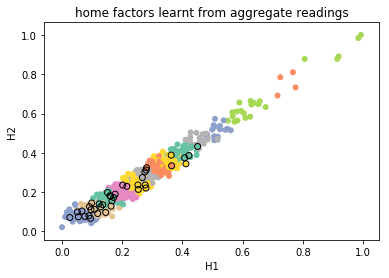

In [47]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

start = len(source_tensor)
# for x1 in range(3):
#     for x2 in range(3):
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[0][:, x1[0]], X[0][:, x2[0]], c = y_pred[0], cmap='Set2', lw=0)
ax.scatter(X[0][start:, x1[0]], X[0][start:, x2[0]], color='black', marker='o', facecolors='none')
plt.xlabel("H1")
plt.ylabel("H2")
plt.title("home factors learnt from aggregate readings")
# plt.savefig("Home_Factors_Agg.pdf", format='pdf')
len(X[0])

# plot the home factors learnt from all readings

533


572

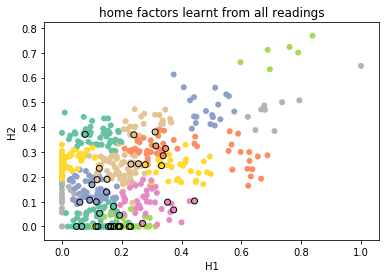

In [48]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

start = len(source_tensor)
# for x1 in range(3):
#     for x2 in range(3):
print start
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X[1][:, x1[1]], X[1][:, x2[1]], c = y_pred[1], cmap='Set2', lw=0)
ax.scatter(X[1][start:, x1[1]], X[1][start:, x2[1]], color='black', marker='o', facecolors='none')
plt.xlabel("H1")
plt.ylabel("H2")
plt.title("home factors learnt from all readings")
# plt.savefig("Home_Factors_Agg.pdf", format='pdf')
len(X[1])

In [49]:
# import Set
# for aggregate readings
start_index = len(source_tensor)
target_agg_cluster = set(y_pred[0][start_index:])
source_agg_index = [i for i, j in enumerate(y_pred[0][:start_index]) if j in target_agg_cluster]
source_agg_sub_tensor = source_tensor[source_agg_index]
# for all readings
target_all_cluster = set(y_pred[1][start_index:])
source_all_index = [i for i, j in enumerate(y_pred[1][:start_index]) if j in target_all_cluster]
source_all_sub_tensor = source_tensor[source_all_index]

In [50]:
print "agg subset cluster: ", target_agg_cluster
print "all subset cluster: ", target_all_cluster
print "agg subset size: ", len(source_agg_index)
print "all subset size: ", len(source_all_index)
print "intersection size: ", len(set(source_agg_index).intersection(source_all_index))

agg subset cluster:  set([0, 1, 3, 4, 6, 9, 10, 11, 12, 13])
all subset cluster:  set([0, 1, 3, 4, 6, 8, 10, 11, 12])
agg subset size:  469
all subset size:  416
intersection size:  396


In [21]:
tensor_copy = source_tensor.copy()
H_all, A_all, T_all, Hs_all, As_all, Ts_all, HATs_all, costs_all = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            source_L,
                                                          a,
                                                          b,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)
print len(H_all)

498.390915785
140.09512203
101.379737927
88.5219212457
83.0967795185
79.9035478544
533


In [22]:
source_agg_sub_static = source_static[source_agg_index]
source_agg_sub_L = get_L(source_agg_sub_static)
source_all_sub_static = source_static[source_all_index]
source_all_sub_L = get_L(source_all_sub_static)

In [24]:

tensor_copy = source_all_sub_tensor.copy()
print tensor_copy.shape
print len(source_all_index)
H_sub_all, A_sub_all, T_sub_all, Hs_sub_all, As_sub_all, Ts_sub_all, HATs_sub_all, costs_sub_all = learn_HAT_adagrad_graph(
                                                            case, tensor_copy,
                                                            source_all_sub_L,
                                                          a,
                                                          b,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)



(496, 7, 12)
496
445.321847076
110.225548901
91.5269908183
79.4700643119
75.2886139074
72.7179241585


In [25]:
len(H_sub_all)

496

In [26]:

tensor_copy = source_agg_sub_tensor.copy()
H_sub_agg, A_sub_agg, T_sub_agg, Hs_sub_agg, As_sub_agg, Ts_sub_agg, HATs_sub_agg, costs_sub_agg = learn_HAT_adagrad_graph(
                                                        case, tensor_copy,
                                                            source_agg_sub_L,
                                                          a,
                                                          b,
                                                          num_iter=3000,
                                                          lr=0.1, dis=True,
                                                          lam=0,
                                                          T_known=T_constant)

423.536743425
97.4303088323
80.463373471
76.6375650917
72.5336835509
69.5461176635


In [93]:
print len(H_sub_agg)

340


In [87]:
import random
k = list((set(list(range(533))) - set(source_inter_index)))
random.shuffle(k)
source_random_index = source_inter_index + k[:11]
source_random_sub_tensor = source_tensor[source_random_index]

In [88]:
source_random_sub_static = source_static[source_random_index]
source_random_sub_L = get_L(source_random_sub_static)


# In[80]:
# tensor_copy = source_diff_sub_tensor.copy()
# H_sub_diff, A_sub_diff, T_sub_diff, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, source_diff_sub_L, a, b, num_iter=3000, lr=0.1, dis=True,lam=0,T_known=T_constant)

tensor_copy = source_random_sub_tensor.copy()
H_sub_diff, A_random, T_sub_diff, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy, source_random_sub_L, a, b, num_iter=3000, lr=0.1, dis=True,lam=0,T_known=T_constant)


337.511458111
83.9348613847
70.9645761731
66.6539883741
62.5728642906
58.5252407985


In [92]:
print len(H_sub_diff)

340


In [91]:
np.set_printoptions(suppress=True)
A_inter - A_sub_agg

array([[[-0.03061587, -0.20064777, -0.69021419],
        [ 1.5556045 , -3.09297337,  2.53362561],
        [-0.65987303,  2.49850927, -1.9185472 ]],

       [[ 0.        ,  6.48628495,  0.43385531],
        [ 0.        , -6.17005524, -0.01851263],
        [-0.26150438, -0.28645832, -0.34664652]],

       [[ 0.54049091,  0.06074   ,  0.10879493],
        [ 1.67661709,  0.05508747,  0.23587062],
        [-4.62962977, -0.15150706, -0.06162457]],

       [[ 0.        ,  0.        ,  0.        ],
        [ 1.46785457,  0.        , -0.03111416],
        [-1.20583584,  0.        ,  0.        ]],

       [[-0.59106391,  0.        , -0.04545712],
        [ 0.63035154,  0.        ,  0.00843537],
        [-0.036139  ,  0.        ,  0.01310675]],

       [[ 0.08102573,  0.        ,  0.        ],
        [ 0.34323957, -0.00117595, -0.00148771],
        [-0.37268321,  0.        , -0.01362727]],

       [[ 0.        ,  0.        ,  0.05143462],
        [ 0.95821884,  0.        , -0.03039041],
        

In [27]:
from scipy.optimize import nnls

n_splits = 10
case = 2
a = 3
b = 3
cost = 'abs'
start = 1
stop = 13


pred_all = {}
pred_sub_all = {}
pred_sub_agg = {}

for random_seed in range(5):
    
    pred_all[random_seed] = {}
    pred_sub_all[random_seed] = {}
    pred_sub_agg[random_seed] = {}
    
    for appliance in APPLIANCES_ORDER:
        pred_all[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}
        pred_sub_all[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}
        pred_sub_agg[random_seed][appliance] = {f:[] for f in range(10, 110, 10)}



kf = KFold(n_splits=n_splits)

for random_seed in range(5):
    print "random seed: ", random_seed
    for train_percentage in range(10, 100, 20):
        print "training percentage: ", train_percentage
        rd = 0
        for train_max, test in kf.split(target_df):
                print "round: ", rd


                num_train = int((train_percentage*len(train_max)/100)+0.5)
                num_test = len(test)

                # get the random training data from train_max based on then random seed
                if train_percentage==100:
                    train = train_max
                else:
                    train, _ = train_test_split(train_max, train_size = train_percentage/100.0, random_state=random_seed)

                # get the index of training and testing data
                train_ix = target_df.index[train]
                test_ix = target_df.index[test]
                print "test_ix: ", test_ix
                print "training set length: ", len(train_ix)

                # create the tensor
                train_test_ix = np.concatenate([test_ix, train_ix])
                df_t, dfc_t = target_df.ix[train_test_ix], target_dfc.ix[train_test_ix]
                tensor = get_tensor(df_t, start, stop)
#                 print tensor.shape
                L_inner = target_L[np.ix_(np.concatenate([test, train]), np.concatenate([test, train]))]


                ############################################################################################
                # Transfer learning: with A_all learned with all Austin Data
                ############################################################################################
                tensor_copy = tensor.copy()
                tensor_copy[:num_test, 1:, :] = np.NaN
                H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            L_inner,
                                                          a,
                                                          b,
                                                          num_iter=2000,
                                                          lr=0.1, dis=False,
                                                          lam=0,
                                                          A_known = A_all,
                                                          T_known=T_constant)
                # get the prediction
                HAT = multiply_case(H, A, T, case)
                for appliance in APPLIANCES_ORDER:
                    pred_all[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))


                #############################################################################################
                # transfer learning: with A_sub_agg learned with subset of Austin Data
                ############################################################################################
                tensor_copy = tensor.copy()
                tensor_copy[:num_test, 1:, :] = np.NaN
                H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            L_inner,
                                                          a,
                                                          b,
                                                          num_iter=2000,
                                                          lr=0.1, dis=False,
                                                          lam=0,
                                                          A_known = A_sub_agg,
                                                          T_known=T_constant)
                # get the prediction
                HAT = multiply_case(H, A, T, case)
                for appliance in APPLIANCES_ORDER:
                    pred_sub_agg[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))

                #############################################################################################
                # transfer learning: with A_sub_all learned with subset of Austin Data
                ############################################################################################
                tensor_copy = tensor.copy()
                tensor_copy[:num_test, 1:, :] = np.NaN
                H, A, T, Hs, As, Ts, HATs, costs = learn_HAT_adagrad_graph(case, tensor_copy,
                                                            L_inner,
                                                          a,
                                                          b,
                                                          num_iter=2000,
                                                          lr=0.1, dis=False,
                                                          lam=0,
                                                          A_known = A_sub_all,
                                                          T_known=T_constant)
                # get the prediction
                HAT = multiply_case(H, A, T, case)
                for appliance in APPLIANCES_ORDER:
                    pred_sub_all[random_seed][appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))




                rd += 1

random seed:  0
training percentage:  10
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
training set length:  3


/home/yj9xs/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/home/yj9xs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:57: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
training set length:  3
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
training set length:  3
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
training set length:  3
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
training set length:  3
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
training set length:  3
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
training set length:  3
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
training set length:  3
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
training set length:  3
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training set length:  3
training percentage:  30
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
training set length:  10
round:  1
test_ix:  Int6

round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
training set length:  24
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
training set length:  24
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
training set length:  24
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
training set length:  24
round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training set length:  25
training percentage:  90
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
training set length:  31
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
training set length:  31
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
training set length:  31
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
training set length:  31
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
training set length:  31
round:  5
test_

round:  9
test_ix:  Int64Index([9612, 9775, 9836], dtype='int64')
training set length:  10
training percentage:  50
round:  0
test_ix:  Int64Index([54, 203, 527, 1450], dtype='int64')
training set length:  17
round:  1
test_ix:  Int64Index([1524, 1731, 2031, 2354], dtype='int64')
training set length:  17
round:  2
test_ix:  Int64Index([2606, 3687, 3864, 3938], dtype='int64')
training set length:  17
round:  3
test_ix:  Int64Index([4083, 4095, 4329, 4495], dtype='int64')
training set length:  17
round:  4
test_ix:  Int64Index([4761, 4934, 5909, 5938], dtype='int64')
training set length:  17
round:  5
test_ix:  Int64Index([6268, 6377, 6429, 6497], dtype='int64')
training set length:  17
round:  6
test_ix:  Int64Index([6547, 7062, 7114, 7409], dtype='int64')
training set length:  17
round:  7
test_ix:  Int64Index([7639, 8061, 8342, 8574], dtype='int64')
training set length:  17
round:  8
test_ix:  Int64Index([8733, 9213, 9370, 9585], dtype='int64')
training set length:  17
round:  9
test_

In [28]:
out_all = {}
out_sub_all = {}
out_sub_agg = {}
for random_seed in range(5):
    out_all[random_seed] = {}
    out_sub_all[random_seed] = {}
    out_sub_agg[random_seed] = {}
    for appliance in APPLIANCES_ORDER[1:]:
        out_all[random_seed][appliance] = {}
        out_sub_all[random_seed][appliance] = {}
        out_sub_agg[random_seed][appliance] = {}
        for f in range(10,110,20):
            s = pd.concat(pred_all[random_seed][appliance][f]).loc[target_df.index]
            if appliance=="hvac":
                out_all[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_all[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

            s = pd.concat(pred_sub_all[random_seed][appliance][f]).loc[target_df.index]
            if appliance=="hvac":
                out_sub_all[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_sub_all[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]
                
            s = pd.concat(pred_sub_agg[random_seed][appliance][f]).loc[target_df.index]
            if appliance=="hvac":
                out_sub_agg[random_seed][appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
            else:   
                out_sub_agg[random_seed][appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

In [29]:
mean_out_all = pd.Panel(out_all).mean(axis=0)
mean_out_sub_all = pd.Panel(out_sub_all).mean(axis=0)
mean_out_sub_agg = pd.Panel(out_sub_agg).mean(axis=0)

# mean_out_all = mean_out_all.rename(columns={'dw':'dw_all', 'fridge':'fridge_all', 'hvac':'hvac_all',
#                                              'mw':'mw_all', 'oven':"oven_all", 'wm':'wm_all'})
# mean_out_sub_all = mean_out_sub_all.rename(columns={'dw':'dw_sub_all', 'fridge':'fridge_sub_all', 'hvac':'hvac_sub_all',
#                                              'mw':'mw_sub_all', 'oven':"oven_sub_all", 'wm':'wm_sub_all'})
# mean_out_sub_agg = mean_out_sub_agg.rename(columns={'dw':'dw_sub_agg', 'fridge':'fridge_sub_agg', 'hvac':'hvac_sub_agg',
#                                              'mw':'mw_sub_agg', 'oven':"oven_sub_agg", 'wm':'wm_sub_agg'})

# all_out = pd.concat([mean_out_all, mean_out_sub_all, mean_out_sub_agg], axis=1)


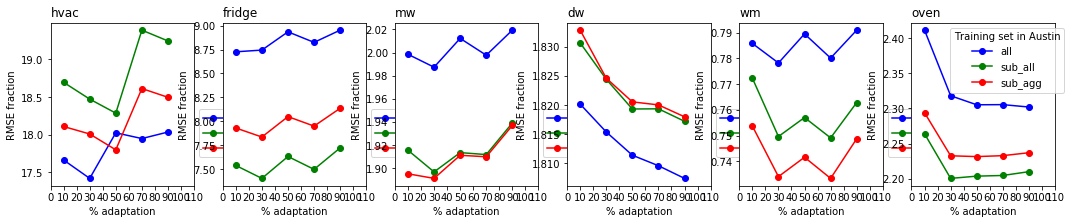

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(3,18))
ax = axes.flatten()
count = 0

for appliance in APPLIANCES_ORDER[1:]:
#     print appliance
#     df1 = all_out[appliance + "_all"]
#     df2 = all_out[appliance + "_sub_all"]
#     df3 = all_out[appliance + "_sub_agg"]
    


    df = pd.concat([mean_out_all[appliance], mean_out_sub_all[appliance], mean_out_sub_agg[appliance]], axis=1)
    pd.DataFrame(df).plot(ax=ax[count],  figsize=(18, 3), marker='o', xlim=(0, 110), color=['b', 'g', 'r'])
    legend = ax[count].legend(loc='best', bbox_to_anchor=(1.0, 0.5))
#     legend.remove()

#     major_ticks = np.arange(0, 101, 20)   

    ax[count].set_xlabel("% adaptation");
    ax[count].locator_params(tight=False, nbins=20, axis='x')
    ax[count].set_ylabel('RMSE fraction')
    ax[count].set_title(appliance, loc="left")
#     ax
    count += 1
plt.legend(['all', 'sub_all', 'sub_agg'], loc='best', bbox_to_anchor=(1.1, 1), title='Training set in Austin')
# plt.savefig("appliance_comparison.pdf", format='pdf')

          dw    fridge       hvac        mw      oven        wm
10  0.054118  2.739254   9.801759  0.084376  0.091787  0.016656
30  0.053976  2.744887   9.666425  0.083906  0.088240  0.016495
50  0.053858  2.804752  10.002118  0.084957  0.087751  0.016734
70  0.053805  2.770183   9.959759  0.084344  0.087759  0.016535
90  0.053740  2.810304  10.007777  0.085258  0.087630  0.016765


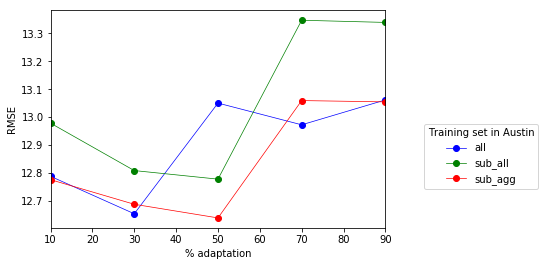

In [31]:
fig, ax = plt.subplots()
error = (pd.DataFrame(mean_out_all)*pd.Series(contri['SanDiego'])).sum(axis=1)
print pd.DataFrame(mean_out_all)*pd.Series(contri['SanDiego'])
error.plot(label='all', marker='o', ax=ax, linewidth=0.7,  color=['b'])
# error.plot(marker='.',ax=ax, legend=False, linewidth=0.6)

error = (pd.DataFrame(mean_out_sub_all)*pd.Series(contri['SanDiego'])).sum(axis=1)
error.plot(label='sub_all',marker='o', ax=ax, linewidth=0.7, color=['g'])
# error.plot(marker='.',ax=ax, legend=False, linewidth=0.6)

error = (pd.DataFrame(mean_out_sub_agg)*pd.Series(contri['SanDiego'])).sum(axis=1)
error.plot(label='sub_agg',marker='o', ax=ax, linewidth=0.7, color=['r'])

plt.ylabel("RMSE")
plt.xlabel("% adaptation")
plt.legend(['all', 'sub_all', 'sub_agg'], loc='best', bbox_to_anchor=(1.1, 0.5), title='Training set in Austin')
# plt.savefig("overall_comparison.pdf", format='pdf')